# Practice: Implement a GRU Language Model

After reading this tutorial, you may know:

*  How to use cotk.dataloader downloading and loading dataset.

*  How to train model with the support of cotk.

*  How to use cotk.metric evaluating models.

cotk does **not** rely on any deep learning framework, so you can even use shallow models like ngram language model. However, this tutorial constructs neural networks with pytorch, so make sure you have installed the following package:

*  Python >= 3.5

*  cotk

*  pytorch >= 1.0.0

*  livelossplot (optional, just for showing loss)


Install necessary packages.

**Note** that currently we use the branch version_up instead of master of cotk
until version_up is merged into master.

In [ ]:
!rm -rf test && mkdir -p test && cd test && git clone -b version_up https://github.com/thu-coai/cotk.git && pip3 install ./cotk
!pip install livelossplot

## Preparing the data

In [2]:
from cotk.dataloader import MSCOCO
from pprint import pprint
dataloader = MSCOCO("resources://MSCOCO_small") # "resources://MSCOCO_small" is a predefined resources name
print("Vocab Size:", dataloader.frequent_vocab_size)
print("First 10 tokens:",  dataloader.frequent_vocab_list[:10])
data = dataloader.get_batch("train", [0]) # get the sample of id 0
pprint(data, width=200)
print(dataloader.convert_ids_to_tokens(data['sent'][0]))

INFO: downloading resources
INFO: name: MSCOCO_small
INFO: source: default
INFO: url: https://cotk-data.s3-ap-northeast-1.amazonaws.com/mscoco_small.zip
INFO: processor: MSCOCO


100%|██████████| 1020154/1020154 [00:00<00:00, 1265532.43B/s]

INFO: resource cached at /root/.cotk_cache/bd12bbf8ce8b157cf620e929bb36379443876ad115951dfeafb63d50b280cff2_temp


Vocab Size: 2597
First 10 tokens: ['<pad>', '<unk>', '<go>', '<eos>', '.', 'a', 'A', 'on', 'of', 'in']
{'sent': array([[  2,   6,  67, 653, 550,  11,   5,  65,  89,  10, 115, 352,  83,
          4,   3]]),
 'sent_allvocabs': array([[  2,   6,  67, 653, 550,  11,   5,  65,  89,  10, 115, 352,  83,
          4,   3]]),
 'sent_length': array([15]),
 'sent_str': ['A blue lamp post with a sign for the yellow brick road .']}
['A', 'blue', 'lamp', 'post', 'with', 'a', 'sign', 'for', 'the', 'yellow', 'brick', 'road', '.']


## Training models

First we construct a simple GRU Language model using *pytorch*.

In [7]:
  import torch
  from torch import nn

  embedding_size = 20
  hidden_size = 20

  class LanguageModel(nn.Module):
      def __init__(self):
          super().__init__()
          self.embedding_layer = nn.Embedding(dataloader.frequent_vocab_size, embedding_size)
          self.rnn = nn.GRU(embedding_size, hidden_size, batch_first=True)
          self.output_layer = nn.Linear(hidden_size, dataloader.frequent_vocab_size)
          self.crossentropy = nn.CrossEntropyLoss()

      def forward(self, data):
          # data is the dict returned by ``dataloader.get_batch``
          sent = data['sent']
          sent_length = data['sent_length']
          # sent is a LongTensor whose shape is (batch_size, sent_length)
          # sent_length is a list whose size is (batch_size)

          incoming = self.embedding_layer(sent)
          # incoming: (batch_size, sent_length, embedding_size)
          incoming, _ = self.rnn(incoming)
          # incoming: (batch_size, sent_length, hidden_size)
          incoming = self.output_layer(incoming)
          # incoming: (batch_size, sent_length, dataloader.vocab_size)

          loss = []
          for i, length in enumerate(sent_length):
              if length > 1:
                  loss.append(self.crossentropy(incoming[i, :length-1], sent[i, 1:length]))
                  # every time step predict next token

          data["gen_log_prob"] = nn.LogSoftmax(dim=-1)(incoming)

          if len(loss) > 0:
             return torch.stack(loss).mean()
          else:
              return 0


If you are familiar with GRU, you can see the codes constructed a network for predicting next token. Then, we will train our model with the help of cotk. (It may takes several minutes to train the model.)

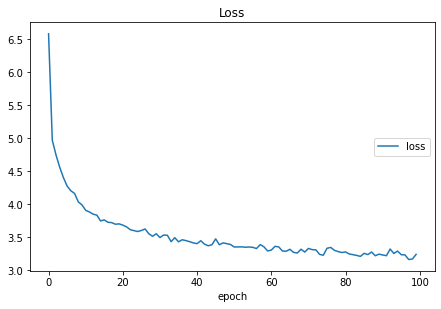

Loss
	loss             	 (min:    3.161, max:    6.577, cur:    3.239)
epoch 100/100


In [8]:
    from livelossplot import PlotLosses
    import numpy as np

    net = LanguageModel()
    optimizer = torch.optim.Adam(net.parameters(), lr=5e-3)
    epoch_num = 100
    batch_size = 16
    plot = PlotLosses()

    for j in range(epoch_num):
        loss_arr = []
        for i, data in enumerate(dataloader.get_batches("train", batch_size)):
            # convert numpy to torch.LongTensor
            data['sent'] = torch.LongTensor(data['sent'])
            net.zero_grad()
            loss = net(data)
            loss_arr.append(loss.tolist())
            loss.backward()
            optimizer.step()
            if i >= 40:
                break # break for shorten time of an epoch
        plot.update({"loss": np.mean(loss_arr)})
        plot.draw()
        print("epoch %d/%d" % (j+1, epoch_num))

## Evaluations

How well our model can fit the data? cotk provides some standard metrics for language generation model.


### Teacher Forcing

`perplexity` is a common used metric and it need the predicted distribution over words. Recall we have set `data["gen_log_prob"]` in previous section, we use it right now.

In [9]:
metric = dataloader.get_teacher_forcing_metric(gen_log_prob_key="gen_log_prob")
for i, data in enumerate(dataloader.get_batches("test", batch_size)):
    # convert numpy to torch.LongTensor
    data['sent'] = torch.LongTensor(data['sent'])
    with torch.no_grad():
        net(data)
    assert "gen_log_prob" in data
    metric.forward(data)
pprint(metric.close(), width=150)

test set restart, 78 batches and 2 left
{'perplexity': 34.22552934535805, 'perplexity hashvalue': '2cc7ecfad6f2b41949648225e043d0b2f8bcf283aae5ef773e821f641b8a9763'}


### Free Run

A language model can also generate sentences by sending the generated token back to input in each step. It is called “freerun” or “inference” mode.

*Pytorch* doesn’t provide a convenience api for freerun, here we implement a simple version that all the prefixes will be recalculated at every step.

In [10]:
metric = dataloader.get_inference_metric(gen_key="gen")
generate_sample_num = 1
max_sent_length = 20

for i in range(generate_sample_num):
    # convert numpy to torch.LongTensor
    data['sent'] = torch.LongTensor([[dataloader.go_id] for _ in range(batch_size)])
    data['sent_length'] = np.array([1 for _ in range(batch_size)])
    for j in range(max_sent_length):
        with torch.no_grad():
            net(data)
            generated_token = torch.multinomial(data['gen_log_prob'].exp()[:, -1], 1)
        data['sent'] = torch.cat([data['sent'], generated_token], dim=-1)

    metric.forward({"gen": data['sent'][:, 1:].tolist()})
pprint(metric.close(), width=250)

100%|██████████| 1250/1250 [00:01<00:00, 1092.16it/s]


{'bw-bleu': 0.0552594607682451,
 'fw-bleu': 0.26895525176213,
 'fw-bw-bleu': 0.0916819725247384,
 'fw-bw-bleu hashvalue': 'b8b072913c122176b5a4bd3954eb1f48c921bb6c9e90b0e4547f2ad98cee56a5',
 'gen': [['A', 'herd', 'of', 'items', 'with', 'different', 'toppings', 'on', 'a', 'snow', 'competition', '.'],
         ['A', 'woman', 'oven', 'sits', 'decorated', 'and', 'forks', 'and', 'flowers', '.'],
         ['A', 'couple', 'of', '<unk>', 'made', 'with', 'into', 'a', 'container', 'of', 'people', '.'],
         ['A', 'person', 'sitting', 'at', 'the', 'snow', 'flower', 'by', 'a', 'drink', 'shows', 'his', 'giraffe', '.'],
         ['A', 'girl', 'standing', 'on', 'the', 'wall', 'outfit', 'in', 'the', 'pedestrian', 'roses', '.'],
         ['A', 'young', 'girl', 'is', 'standing', 'by', 'businesses', 'raised', '.'],
         ['A', 'small', 'baseball', 'pitcher', 'down', 'a', 'tennis', 'ball', '.'],
         ['A', 'boat', 'and', 'bananas', 'train', 'in', 'a', 'field', '.'],
         ['A', 'white', 'dou

### Hash value

Hash value is for checking whether you use the test set correctly. We can refer to the dashboard for the state of art on this dataset, and we find our hashvalue is correct.

However, if teacher forcing is tested as following codes, we will see a different hash value, which means the implementation is not correct.

In [11]:
metric = dataloader.get_teacher_forcing_metric(gen_log_prob_key="gen_log_prob")
for i, data in enumerate(dataloader.get_batches("test", batch_size)):
    # convert numpy to torch.LongTensor
    data['sent'] = torch.LongTensor(data['sent'])
    with torch.no_grad():
        net(data)
    assert "gen_log_prob" in data
    metric.forward(data)
    if i >= 15: #ignore the following batches
        break
pprint(metric.close(), width=150)

test set restart, 78 batches and 2 left
{'perplexity': 31.935582929323076, 'perplexity hashvalue': 'd38265b09387b07be8461f54a7879250b196b0f5bbd3669dc5c6cd17958d81f8'}
